(9216,)


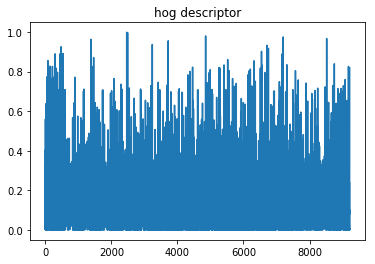

In [3]:
import skimage
%matplotlib inline
from skimage import io
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import ndimage

import pywt
from skimage import data, img_as_float
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.util.shape import view_as_blocks

img = rgb2gray(data.camera())
img = resize(img, (256,256), mode='reflect')

# computes the L2 norm of an vector
# this function is needed for the block normalization
# input vector (or array-like) 
def normalize_vector(vector):
    
    length_vector = 0
    
    for i in range(0,np.shape(vector)[0]):
        length_vector = length_vector + vector[i]**2
        
    length_vector = math.sqrt(length_vector)
    
    for i in range(0,np.shape(vector)[0]):
        vector[i] = vector[i] / length_vector

    return vector


def simple_HOG(img):
    hog_descriptor = []
    
    # images with the gradients presented in horiz./vertic.
    img_gradients_x = ndimage.sobel(img, axis=0, mode='constant')
    img_gradients_y = ndimage.sobel(img, axis=1, mode='constant')
    
    # images presenting the gradient magnitude and direction(in °)
    img_gradient_magnitude = np.hypot(img_gradients_x, img_gradients_y)
    img_gradient_direction = np.rad2deg(np.arctan2(img_gradients_y, img_gradients_x))
    
    # magnitudes of gradients in blocks and cells
    #block_gradient_magnitude = view_as_blocks(img_gradient_magnitude, block_shape=(16,16))
    cell_gradient_magnitude = view_as_blocks(img_gradient_magnitude, block_shape=(8,8))
        
    # directions of gradients in blocks and cells
    block_gradient_direction = view_as_blocks(img_gradient_direction, block_shape=(16,16))
    cell_gradient_direction = view_as_blocks(img_gradient_direction, block_shape=(8,8))
    
    dim = np.shape(block_gradient_direction) # dim of the dircetion (magnitude is the same)
   
    for i in range(0,dim[0]):
        for j in range(0,dim[1]):
            # iterate over all blocks (no block overlapping here) and calculate the 4 direction histograms in a 8x8 cell, weighted by their magnitude
            # the indices are multiplied by two, since a cell is the half size of a block
            cell_hist1, bin_edges1 = np.histogram(cell_gradient_direction[i*2][j*2], bins=9, range=(0,180), weights=cell_gradient_magnitude[i*2][j*2])
            cell_hist2, bin_edges2 = np.histogram(cell_gradient_direction[i*2][j*2+1], bins=9, range=(0,180), weights=cell_gradient_magnitude[i*2][j*2+1])
            cell_hist3, bin_edges3 = np.histogram(cell_gradient_direction[i*2+1][j*2], bins=9, range=(0,180), weights=cell_gradient_magnitude[i*2+1][j*2])
            cell_hist4, bin_edges4 = np.histogram(cell_gradient_direction[i*2+1][j*2+1], bins=9, range=(0,180), weights=cell_gradient_magnitude[i*2+1][j*2+1])
            
            block_hist = np.concatenate((cell_hist1, cell_hist2, cell_hist3, cell_hist4), axis=0)
            block_L2_normalized = normalize_vector(block_hist)
           
            hog_descriptor = np.concatenate((hog_descriptor, block_L2_normalized), axis=0) 
    
    return hog_descriptor





desc = simple_HOG(img)
print(np.shape(desc))

plt.title('hog descriptor')
plt.plot(desc)